In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, GaussianNoise, Input, Rescaling
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import ModelCheckpoint

2025-06-08 16:53:57.689510: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 16:53:57.696703: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 16:53:57.746837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-08 16:53:57.746993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-08 16:53:57.748611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
!pip install kagglehub==0.3.12


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:


# Install the kagglehub package
!pip install kagglehub

# Re-run the code to ensure the module is now available
import kagglehub
import os
import numpy as np

# Download latest version and get the path to the downloaded data
downloaded_dataset_path = kagglehub.dataset_download("rijulshr/pneumoniamnist")

print("Path to dataset files:", downloaded_dataset_path)

# Now, construct the full path to the .npz file using the downloaded path
# The .npz file is typically directly within the downloaded directory
npz_file_name = "pneumoniamnist.npz"
full_npz_path = os.path.join(downloaded_dataset_path, npz_file_name)

print("Attempting to load data from:", full_npz_path)

# Load the dataset using the corrected path
try:
    dataset = np.load(full_npz_path)
    print("Dataset loaded successfully.")
    # Now you can proceed with inspecting the shape
    print("Training images shape:", dataset["train_images"].shape)
    print("Training labels shape:", dataset["train_labels"].shape)

except FileNotFoundError:
    print(f"Error: The file '{full_npz_path}' was not found.")
    print("Please verify that 'pneumoniamnist.npz' exists within the downloaded dataset directory.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

# The rest of your code to normalize, check distribution, etc. can follow
# assuming the 'dataset' variable is successfully loaded.

# For example, the normalization part:
# def normalization(image_set):
#     min_val = np.min(image_set)
#     max_val = np.max(image_set)
#     difference = max_val - min_val
#     return (image_set - min_val) / difference

# if 'dataset' in locals(): # Check if dataset was loaded successfully
#     xtrain = normalization(dataset["train_images"].reshape(-1, 28, 28, 1))
#     ytrain = dataset["train_labels"]
#     # ... and so on for validation and test data
# else:
#     print("Dataset not loaded, skipping normalization and subsequent steps.")


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Path to dataset files: /root/.cache/kagglehub/datasets/rijulshr/pneumoniamnist/versions/1
Attempting to load data from: /root/.cache/kagglehub/datasets/rijulshr/pneumoniamnist/versions/1/pneumoniamnist.npz
Dataset loaded successfully.
Training images shape: (3882, 28, 28)
Training labels shape: (3882, 1)


In [35]:



# Extract training, validation, and test labels from the dataset
ytrain = dataset["train_labels"]
yvalid = dataset["val_labels"]
ytest = dataset["test_labels"]

# Ensure labels are cast to float32
ytrain = ytrain.astype('float32')
yvalid = yvalid.astype('float32')
ytest = ytest.astype('float32')

In [13]:
xtrain = normalization(dataset["train_images"].reshape(-1, 28, 28, 1))
ytrain = dataset["train_labels"]

xvalid = normalization(dataset["val_images"].reshape(-1, 28, 28, 1))
yvalid = dataset["val_labels"]

xtest  = normalization(dataset["test_images"].reshape(-1, 28, 28, 1))
ytest = dataset["test_labels"]

Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


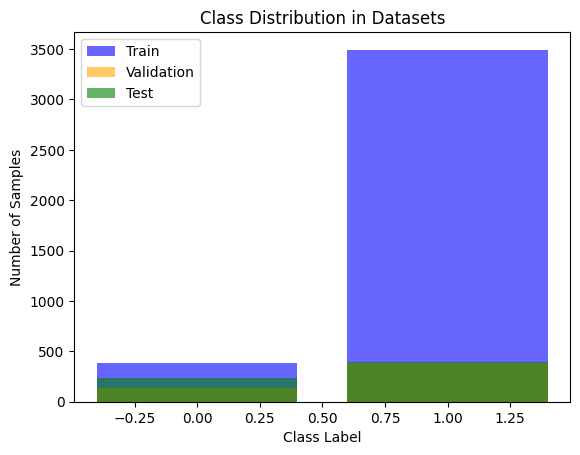

In [16]:
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")

# Optional: visualize imbalance
plt.bar(unique_train, counts_train, color='blue', alpha=0.6, label='Train')
plt.bar(unique_val, counts_val, color='orange', alpha=0.6, label='Validation')
plt.bar(unique_test, counts_test, color='green', alpha=0.6, label='Test')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.legend()
plt.title("Class Distribution in Datasets")
plt.show()


In [19]:
data_augmentation = Sequential([
    Input(shape=(28, 28, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.3),  # Increased rotation
    RandomZoom(0.3),      # Increased zoom
    RandomTranslation(0.3, 0.3),  # Increased translation
    GaussianNoise(0.3),   # Increased noise
])

AUTOTUNE = tf.data.AUTOTUNE

# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_ds = train_ds.shuffle(buffer_size=1024).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(64).prefetch(AUTOTUNE)

# Validation and test datasets (without augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((xvalid, yvalid)).batch(64).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest)).batch(64).prefetch(AUTOTUNE)


In [22]:
from tensorflow.keras.applications import EfficientNetB0

input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

x = Concatenate()([input_layer, input_layer, input_layer])

# Load base model (EfficientNetB0 instead of ResNet50)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = True  # Enable fine-tuning
for layer in base_model.layers[:-20]:  # Unfreeze more layers for better feature extraction
    layer.trainable = True

weight_reg = L2(1e-4)   # L2 for weights
bias_reg = L1(1e-6)     # L1 for biases

# Modified model head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)  # Increased dropout
x = Dense(256, activation='relu',  # Increased units
          kernel_regularizer=weight_reg,
          bias_regularizer=bias_reg)(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid',
               kernel_regularizer=weight_reg,
               bias_regularizer=bias_reg)(x)

model = Model(inputs=input_layer, outputs=output)

model.summary()
              

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 28, 28, 3)            0         ['input_2[0][0]',             
                                                                     'input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 28, 28, 3)            0         ['concatenate[0][0]']         
                             

In [25]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-7)
        specificity = self.tn / (self.tn + self.fp + 1e-7)
        return (recall + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)



class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [28]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Callback to restore best weights after training
restore_best_weights = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)


In [31]:
# Convert labels to float32 to avoid type mismatch errors
ytrain = ytrain.astype('float32')
yvalid = yvalid.astype('float32')
ytest = ytest.astype('float32')

# Handle class imbalance by computing class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(ytrain.flatten()), y=ytrain.flatten())
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,  # Reduced learning rate for stability
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Recompile the model with the updated loss function and learning rate schedule
model

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 0.0771 - balanced_accuracy: 0.7850 - auc: 0.8571 - f1_score: 0.9163
Epoch 1: val_loss did not improve from 0.04467
61/61 [==============================] - 37s 258ms/step - loss: 0.0771 - balanced_accuracy: 0.7850 - auc: 0.8571 - f1_score: 0.9163 - val_loss: 0.2176 - val_balanced_accuracy: 0.5000 - val_auc: 0.3722 - val_f1_score: 0.8521
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 0.0706 - balanced_accuracy: 0.7263 - auc: 0.8078 - f1_score: 0.9107
Epoch 2: val_loss did not improve from 0.04467
61/61 [==============================] - 13s 209ms/step - loss: 0.0706 - balanced_accuracy: 0.7263 - auc: 0.8078 - f1_score: 0.9107 - val_loss: 0.3094 - val_balanced_accuracy: 0.5000 - val_auc: 0.7825 - val_f1_score: 0.8521
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 0.0547 - balanced_accuracy: 0.7120 - auc: 0.7864 - f1_score: 0.8557
Epoch 3: val_loss did not improve from 0.04467
61/

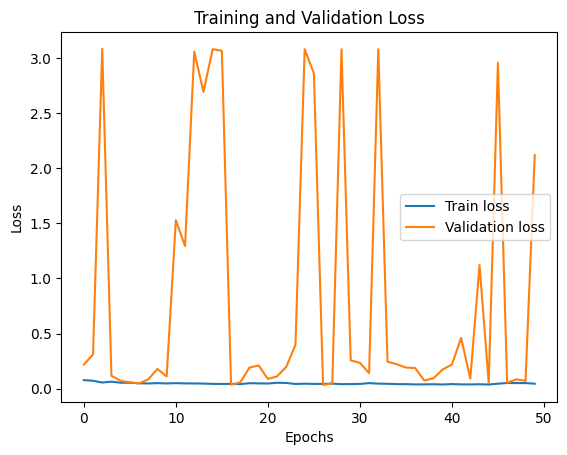

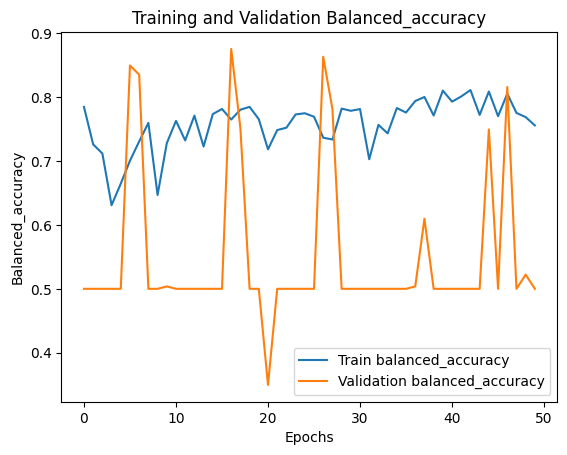

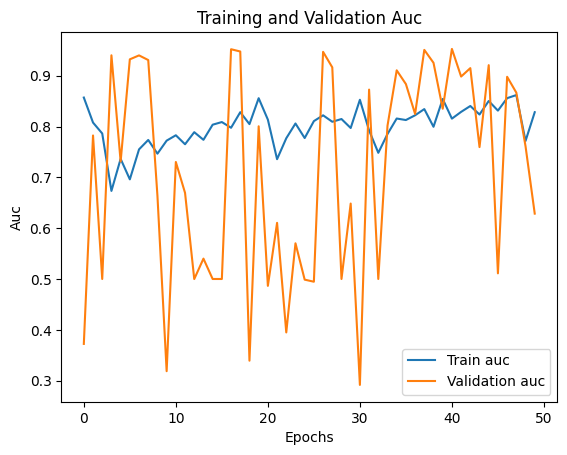

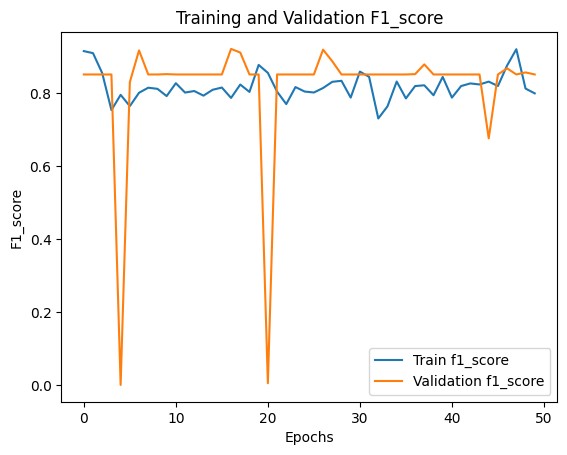

In [36]:

# Specifically, 'y_true' is of type uint8, while 'y_pred' is float32.
# To fix this, we need to cast 'y_true' to float32 within the focal loss function.

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

# Recompile the model with the updated loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        BalancedAccuracy(name='balanced_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')
    ]
)

# Train the model and store the history
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,  # Add class weights to handle imbalance
    callbacks=[checkpoint, restore_best_weights]
)

# Evaluate the model on the test set
test_metrics = model.evaluate(xtest, ytest, verbose=0)
predictions = model.predict(xtest)
print("Sample Predictions:", predictions[:5])  # Debugging predictions
print("True Labels:", ytest[:5])               # Debugging true labels
print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test F1-Score: {test_metrics[3]:.4f}")

# Plot training history (assuming plot_metrics is defined)
def plot_metrics(history):
    """Function to plot training and validation metrics."""
    metrics = ['loss', 'balanced_accuracy', 'auc', 'f1_score']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()
        plt.show()

# Call the function to plot metrics
plot_metrics(history)

In [37]:
val_metrics = model.evaluate(xvalid, yvalid, verbose=0)
test_metrics = model.evaluate(xtest, ytest, verbose=0)

print(f"Validation Loss: {val_metrics[0]:.4f}")
print(f"Validation Balanced Accuracy: {val_metrics[1]:.4f}")
print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test F1-Score: {test_metrics[3]:.4f}")

Validation Loss: 2.1210
Validation Balanced Accuracy: 0.5000
Test Loss: 3.5042
Test Balanced Accuracy: 0.5000
Test AUC: 0.5662
Test F1-Score: 0.7692


In [14]:
!pip install keras_tuner==1.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 24.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [38]:


# Install the keras-tuner package
!pip install keras-tuner

# Re-run the code to ensure the module is now available
import keras_tuner as kt

def build_model(hp):
    input_layer = Input(shape=(28, 28, 1))
    x = Concatenate()([input_layer, input_layer, input_layer])
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = hp.Boolean('fine_tune', default=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1))(x)
    x = Dense(hp.Int('units', 64, 256, step=64), activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='pneumonia_tuning'
)

tuner.search(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Reloading Tuner from my_dir/pneumonia_tuning/tuner0.json


2/2 [==============================] - 2s 51ms/step
/tmp/ipykernel_522/1475722554.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(labels[idx])]}, Pred: {class_names[int(predictions[idx] > 0.5)]} ({predictions[idx][0]:.2f})")


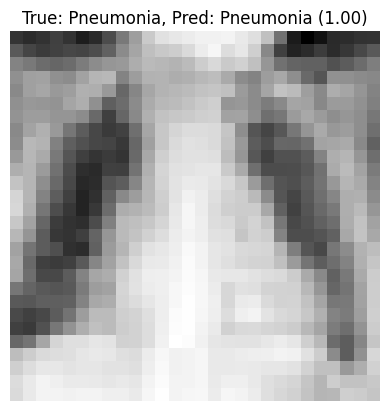

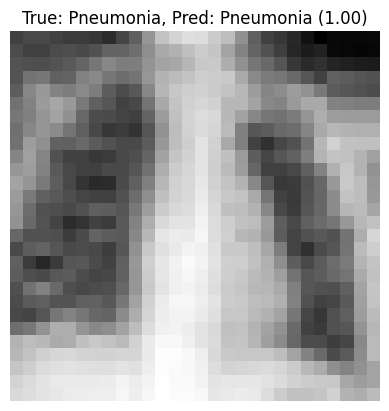

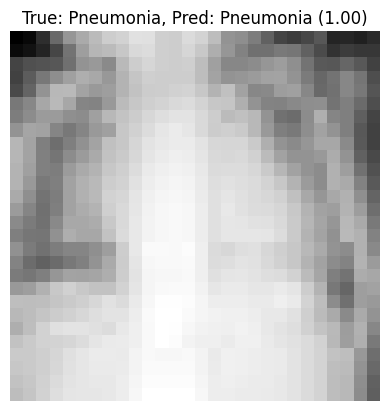

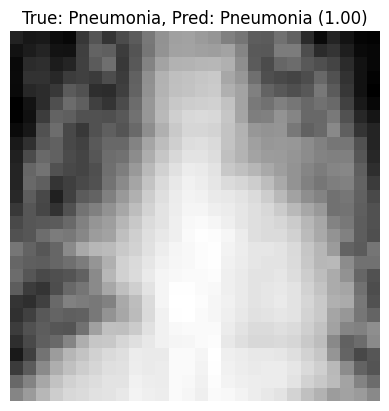

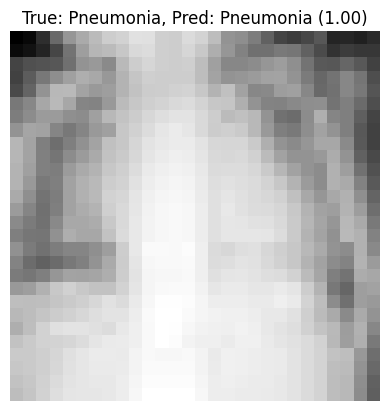


    Clinical Report
    ----------------
    Test Loss: 3.5042
    Test Balanced Accuracy: 0.5000
    Test AUC: 0.5662
    Test F1-Score: 0.7692
    


In [39]:
# Clinical Integration Block

def visualize_predictions(model, test_ds, class_names):
    """Visualize sample predictions with images and probabilities."""
    import random

    # Get a batch of test data
    for images, labels in test_ds.take(1):
        predictions = model.predict(images)
        for i in range(5):  # Show 5 random samples
            idx = random.randint(0, len(images) - 1)
            plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
            plt.title(f"True: {class_names[int(labels[idx])]}, Pred: {class_names[int(predictions[idx] > 0.5)]} ({predictions[idx][0]:.2f})")
            plt.axis('off')
            plt.show()

# Define class names
class_names = ["Normal", "Pneumonia"]

# Visualize predictions
visualize_predictions(model, test_ds, class_names)

# Generate a Clinical Report
def generate_clinical_report(test_metrics, class_names):
    """Generate a clinical report summarizing model performance."""
    report = f"""
    Clinical Report
    ----------------
    Test Loss: {test_metrics[0]:.4f}
    Test Balanced Accuracy: {test_metrics[1]:.4f}
    Test AUC: {test_metrics[2]:.4f}
    Test F1-Score: {test_metrics[3]:.4f}
    """
    print(report)

# Example usage
test_metrics = model.evaluate(test_ds, verbose=0)
generate_clinical_report(test_metrics, class_names)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df00cb43-0d3f-4d84-a6b3-998162e4d89e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>